# Water Bodies Segmentation

In [1]:
# %pip install -r requirements.txt

In [2]:
import os
import shutil
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.unet import unet
from src.unet2plus import unet2plus
from src.unet3plus import unet3plus
from src.losses import init_num_classes, iou, dice_coef, dice_coef_loss

import tensorflow as tf
from tensorflow.keras import ops
import keras_cv

from glob import glob
import os
from functools import partial

import seaborn as sns

d:\CTU Studying\CT550\CT550-Code\ct550-waterbodies_segment\build_model\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
input_shape = (512, 512, 3)
num_classes = 2
batch_size = 2
gradient_accumulation_steps = 16 # Actual batch size = batch_size * gradient_accumulation_steps
num_epochs = 1000
learning_rate = 1e-4
weight_decay = 0.0
initial_epoch = 0

init_num_classes(num_classes)

## Data Loader And Augmentation

In [4]:
def load_data(path):
  train_images = sorted(glob(os.path.join(path, 'train', 'images', '*')))
  train_masks = sorted(glob(os.path.join(path, 'train', 'masks', '*')))

  test_images = sorted(glob(os.path.join(path, 'test', 'images', '*')))
  test_masks = sorted(glob(os.path.join(path, 'test', 'masks', '*')))

  validation_images = sorted(glob(os.path.join(path, 'val', 'images', '*')))
  validation_masks = sorted(glob(os.path.join(path, 'val', 'masks', '*')))

  return (train_images, train_masks), (test_images, test_masks), (validation_images, validation_masks)


def read_image(path, input_shape):
  path = path.decode()

  img = tf.keras.utils.load_img(
      path,
      color_mode="rgb",
      target_size=(input_shape[0], input_shape[1]),
      interpolation="bilinear",
  )
  img = tf.keras.utils.img_to_array(img, dtype='float32')
  return img


def read_mask(path, input_shape):
  path = path.decode()

  img = tf.keras.utils.load_img(
      path,
      color_mode="grayscale",
      target_size=(input_shape[0], input_shape[1]),
      interpolation="bilinear",
  )
  img = tf.keras.utils.img_to_array(img, dtype='float32')
  return img


def tf_parse(image, mask, input_shape):
  def _parse(image, mask):
    image = read_image(image, input_shape)
    mask = read_mask(mask, input_shape)
    return image, mask

  image, mask = tf.numpy_function(_parse, [image, mask], [tf.float32, tf.float32])
  image.set_shape([input_shape[0], input_shape[1], input_shape[2]])
  image = tf.cast(image, tf.float32) / 255.0
  mask.set_shape([input_shape[0], input_shape[1], 1])
  return image, mask


def tf_dataset(image, mask, batch_size, input_shape, augment=False):
  dataset = tf.data.Dataset.from_tensor_slices((image, mask))
  dataset = dataset.map(partial(tf_parse, input_shape=input_shape), num_parallel_calls=tf.data.AUTOTUNE)
  if (augment != False):
    dataset_augmented = dataset.map(Augment(augment['random_flip'], augment['random_contrast'], augment['random_brightness']), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.concatenate(dataset_augmented)
  num_samples = len(dataset)
  dataset = dataset.shuffle(num_samples)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset, num_samples


In [5]:
class Augment(tf.keras.layers.Layer):
  def __init__(self,
               random_flip,
               random_contrast,
               random_brightness):
    super().__init__()
    self.random_flip = random_flip
    self.random_contrast = random_contrast
    self.random_brightness = random_brightness

    if random_flip:
      self.augment_RandomFlip = tf.keras.layers.RandomFlip(mode='horizontal')
    if random_contrast:
      self.augment_RandomContrast = tf.keras.layers.RandomContrast(factor=0.2)
    if random_brightness:
      self.augment_RandomBrightness = tf.keras.layers.RandomBrightness(factor=0.2, value_range=[0.0, 1.0])

  def call(self, inputs, labels):
    labels = labels[:, :, 0]
    labels = tf.stack([labels, labels, labels], -1)

    labels = tf.cast(labels, 'float32')
    output = tf.concat([inputs, labels], -1)

    if self.random_flip:
      output = self.augment_RandomFlip(output)

    labels_augmented = output[:, :, 4]
    labels_augmented = tf.expand_dims(tf.cast(labels_augmented, 'float32'), axis=-1)

    if self.random_contrast:
      output = self.augment_RandomContrast(output)
    if self.random_brightness:
      output = self.augment_RandomBrightness(output)

    inputs_augmented = output[:, :, 0:3]

    return inputs_augmented, labels_augmented

In [6]:
def display_images(display_list):
  plt.figure(figsize=(10, 10))
  title = ['Input Image', 'True Mask',
           'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [7]:
# Load datasets
(train_images, train_masks), (test_images, test_masks), (validation_images, validation_masks) = load_data('dataset')

train_dataset, train_num_samples = tf_dataset(
    train_images, 
    train_masks, 
    batch_size, 
    input_shape, 
    augment=False
)
test_dataset, test_num_samples = tf_dataset(test_images, test_masks, batch_size, input_shape, augment=False)
validation_dataset, val_num_samples = tf_dataset(validation_images, validation_masks, batch_size, input_shape, augment=False)

## The Segmentation Model

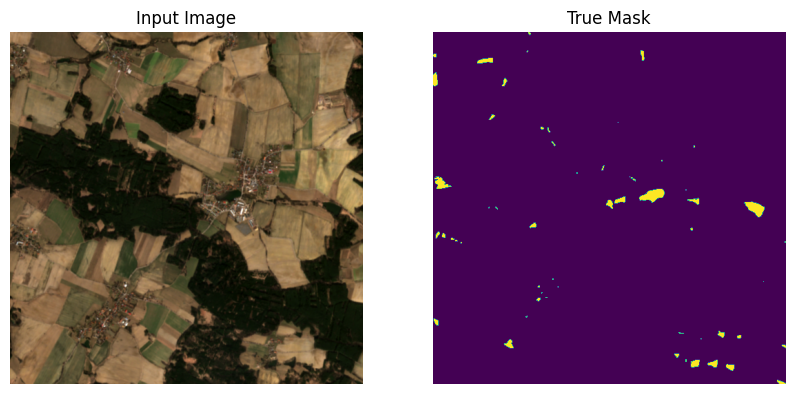

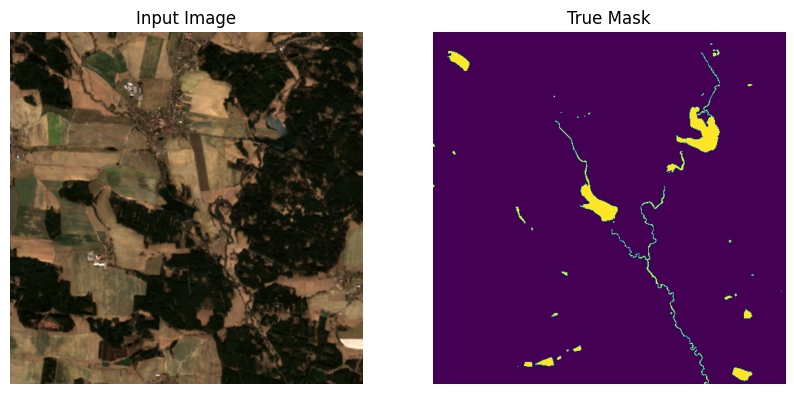

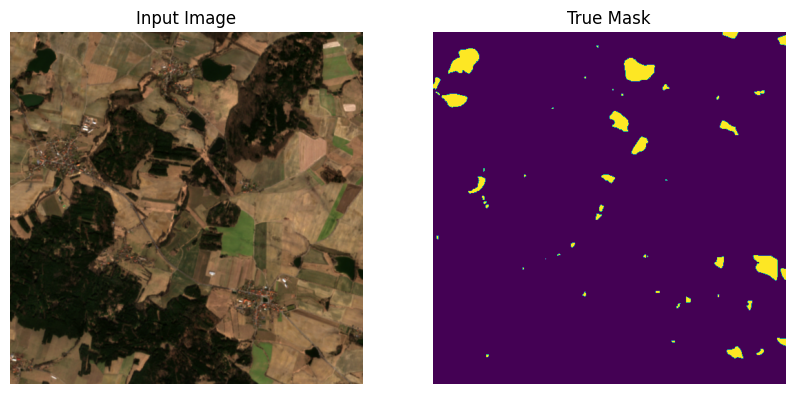

In [8]:
# Visualize the training dataset
for image, mask in train_dataset.take(3):
    display_images([image[0], mask[0]])

##### Choose a model to training and command other models

In [9]:
# model = unet(input_shape=input_shape, num_classes=num_classes)
# model = unet2plus(input_shape=input_shape, num_classes=num_classes)
model = unet3plus(input_shape=input_shape, num_classes=num_classes, use_pretrain = False, fine_tune_at = False)

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        gradient_accumulation_steps=gradient_accumulation_steps,
    ),
    loss=dice_coef_loss(),
    metrics=[
        dice_coef,
        iou,
    ],
)

model.summary()

Model: "UNet_3Plus"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_4[0][0]  

 Total params: 26,977,474 (102.91 MB)

 Trainable params: 26,966,978 (102.87 MB)

 Non-trainable params: 10,496 (41.00 KB)

## Custom Callbacks

In [11]:
csv_logger = tf.keras.callbacks.CSVLogger(
    'logs/result.csv',
    separator=",",
    append=True,
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'logs/checkpoint.model.keras',
    monitor="val_loss",
    verbose=0,
    mode="min",
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=10,
)

callbacks=[
    csv_logger,
    model_checkpoint,
    early_stopping,
]

## Implement Class Weight

In [12]:
unbatch_train_ds = train_dataset.unbatch()
true_masks = list(unbatch_train_ds.map(lambda x, y: y))

pixel_0 = pixel_1 = 0

for mask in true_masks:
   pixel_0 += np.sum(mask==0)
   pixel_1 += np.sum(mask==1)

total_pixel = np.sum([pixel_0, pixel_1])

weight_for_0 = total_pixel/ (2 * pixel_0 )
weight_for_1 = total_pixel/ (2 * pixel_1)

print('Weight for class 0: {:.10f}'.format(weight_for_0))
print('Weight for class 1: {:.10f}'.format(weight_for_1))

class_weights = tf.constant([weight_for_0, weight_for_1])
class_weights = class_weights/tf.reduce_sum(class_weights)

def add_sample_weights(image, label):
    class_weights = tf.constant([weight_for_0, weight_for_1])
    class_weights = class_weights/tf.reduce_sum(class_weights)
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
    return image, label, sample_weights

Weight for class 0: 0.5172539122
Weight for class 1: 14.9894674634


## Run Experiment

In [13]:
# def run_experiment(model, resume=False):
#     if resume == False:
#         initial_epoch=0
#         try:
#             shutil.rmtree('logs')
#         except:
#             print('directory not found')
#         os.mkdir('logs')
#     else:
#         model.load_weights('logs/checkpoint.model.keras')
#         df = pd.read_csv('logs/result.csv')
#         initial_epoch = df['epoch'].values[-1]

#     model.fit(
#         train_dataset.map(add_sample_weights),
#         epochs=num_epochs,
#         initial_epoch=initial_epoch,
#         callbacks=callbacks,
#         validation_data=validation_dataset,
#     )

#     model.save("logs/model.keras")

#     return model

In [14]:
# model = run_experiment(model, resume=False)

## Model evaluation

In [15]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [ ]:
def get_test_image_and_annotation_arrays():
    ds = test_dataset.unbatch()
    ds_num_img = test_num_samples
    ds = ds.batch(ds_num_img)

    for y_true_images, y_true_segments in ds.take(ds_num_img):
        y_true_images = y_true_images
        y_true_segments = y_true_segments

    return y_true_images, y_true_segments

y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

In [17]:
def plot_history(csv):
    df = pd.read_csv(csv)
    df[['epoch', 'loss', 'val_loss']].plot(
        x='epoch',
        y=['loss', 'val_loss'],
        xlabel='epoch',
        ylabel='loss',
        title='Train and Validation Loss Over Epochs'
    )
    plt.legend()
    plt.grid()
    plt.show()

In [18]:
def compute_metrics(y_trues, y_preds, show_ncm=False):
    y_trues = y_trues.numpy()
    y_preds = y_preds.numpy()
    TP = TN = FP = FN = 0

    for y_true, y_pred in zip(y_trues, y_preds):
        TP += np.sum((y_true == 1) & (y_pred == 1))
        TN += np.sum((y_true == 0) & (y_pred == 0))
        FP += np.sum((y_true == 0) & (y_pred == 1))
        FN += np.sum((y_true == 1) & (y_pred == 0))

    precision = TP / ( TP + FP )
    recall = TP / ( TP + FN )
    dice = 2 * TP / (2 * TP + FN + FP)
    iou = TP / (TP + FN + FP)

    cm = [[TP,FN],
          [FP,TN]]

    print(f"precision: {round(precision,4)}")
    print(f"recall: {round(recall,4)}")
    print(f"dice score: {round(dice,4)}")
    print(f"iou: {round(iou,4)}")

    if show_ncm==True:
        ncm = np.round(cm/np.sum(cm, axis=1).reshape(-1,1),4)
        fig, ax = plt.subplots(figsize=(12, 8))
        ax = sns.heatmap(ncm, annot=True, cmap='Blues', fmt='g', annot_kws={"size":15})
        ax.set_title('Normalized confusion matrix\n\n', fontsize=15);
        ax.set_xlabel('\nPredicted label', fontsize=15)
        ax.set_ylabel('True label ', fontsize=15);
        ax.xaxis.set_ticklabels(['1','0'], fontsize=13)
        ax.yaxis.set_ticklabels(['1','0'], fontsize=13)
        plt.savefig('logs/normalized_confusion_matrix.png')
        plt.show()

In [19]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_images([image[0], mask[0], create_mask(pred_mask)[0]])
            compute_metrics(mask[0], create_mask(pred_mask)[0])

In [20]:
model.load_weights('results/augmented/brightness/model.keras')

y_pred_masks = model.predict(y_true_images, batch_size=batch_size)
y_pred_masks = create_mask(y_pred_masks)

compute_metrics(y_true_segments, y_pred_masks, show_ncm=True)
plot_history('results/augmented/brightness/result.csv')

show_predictions(test_dataset, num=101)

d:\CTU Studying\CT550\CT550-Code\ct550-waterbodies_segment\build_model\venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 296 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


51/51 ━━━━━━━━━━━━━━━━━━━━ 937s 18s/step


ValueError: operands could not be broadcast together with shapes (512,512,1) (1024,1024,1) 

In [ ]:
# !zip -r logs.zip logs